# Demo: Integration over Closed Contours & Application to Special Function Evaluation

In [1]:
import numpy as np

from numpy.fft import fft, ifft

from scipy.special import factorial, jn

import matplotlib.pyplot as plt

import cmocean
import cmocean.cm as cmo

import time

import sys

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

In this demo...

## Suggested References 

- Aleksei Markushevich, *Theory of Functions of a Complex Variable*, Chelsea, 1977, trans. Richard Silverman

- Lloyd Nick Trefethen, *Spectral Methods in MATLAB*, SIAM, 2000

## Background Theory

## Numerical Examples

### Example 1: Accuracy Investigation of Fourier Orthogonality Formulas 

First, we confirm that our method reproduces the familiar trigonometric orthogonality relations. 

In [2]:
def evaluate_trig_integrals(m,n, num_samples = 2**5):
    # compute L^2 inner product of e^{imx}, e^{inx} on the unit circle
    
    theta = np.linspace(0., 2.*np.pi, num_samples, endpoint = False)
    
    integrand  = np.exp(1j*m*theta)*np.exp(-1j*n*theta)
    
    out = 2.*np.pi*np.mean(integrand, axis=0)
    
    return out 

In [3]:
evaluate_trig_integrals(16,10) # remember not to go too high bcz of Nyquist-Shannon limit!

(-3.3879809662455247e-15+6.975736996017264e-16j)

Playing around with this code reproduces the orthogonality rule: we get $0$ if $m\neq n$ and $2\pi$ otherwise. TODO: convergence plot as a function of num_samples to make this more visual. 

### Example 2: Evaluation of Bessel Functions of the First Kind

In [4]:
def bessel(x, order = 0, num_samples = 2**5): 
    # TODO: make params hyperparams or store them more nicely
    
    N = np.size(x)
    
    theta = np.linspace(0., 2.*np.pi, num_samples, endpoint = False)
    
    # do two smooth lines of code to avoid a loop
    arg = np.reshape(np.kron(np.sin(theta),x), (num_samples,N)) - order*np.tile(theta,(N,1)).T
        
    out = np.real(np.mean(np.exp(1j*arg), axis=0))
            
    return out

In [5]:
bessel(0) # check basic diagnostic

array([1.])

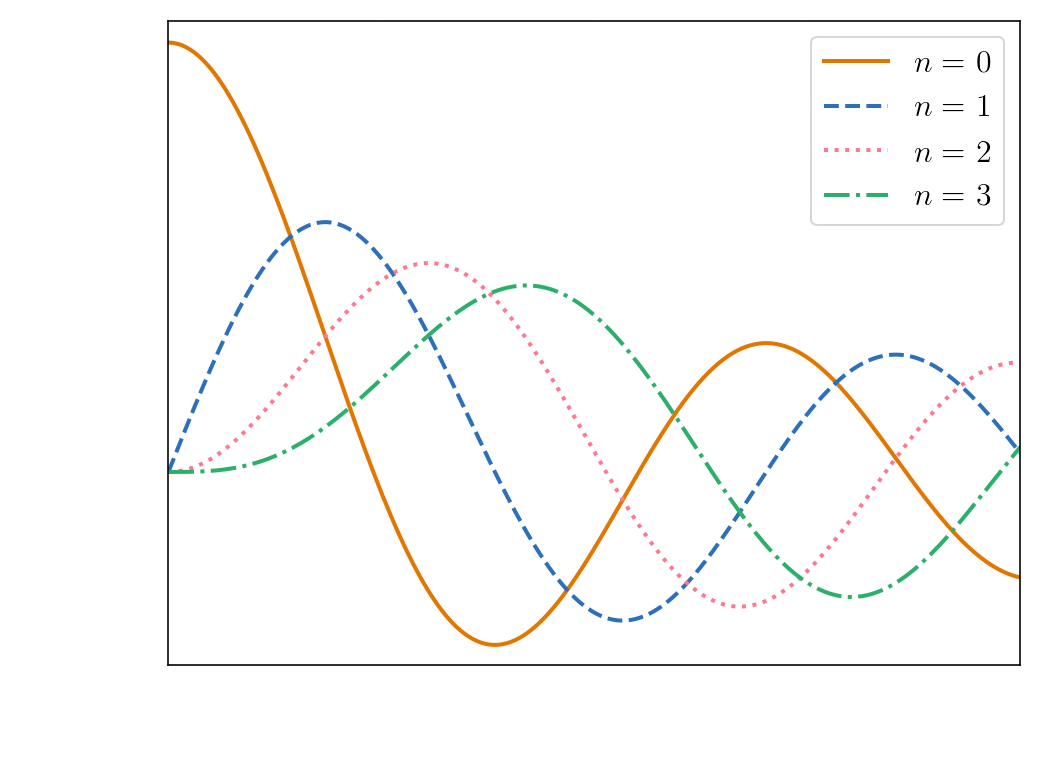

In [17]:
fig, ax = plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#plt.rcParams['figure.dpi']= 600
    
xx = np.linspace(0,10.,200) 

# colors and styles
colors =['xkcd:pumpkin', 'xkcd:medium blue', 'xkcd:carnation', 'xkcd:jade green']
styles = ['-', '--', ':', '-.']

for n in [0,1,2,3]:

    yy = bessel(xx, n)
    plt.plot(xx, yy, color=colors[n], linewidth='2', linestyle=styles[n], label='$n = $ %i'%(n))

ax.legend(fontsize=16)

plt.xlim([0,10])
plt.ylim([-0.45,1.05])

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$J_{n}(x)$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)

#ax.axes.set_aspect(scaled)

plt.show()

In [7]:
#TODO: accuracy discussion with visuals! 

### Example 3: Evaluation of the $\Gamma$-Function via Hankel's Contour Integral Formula

Thanks to Herr Hankel, we have the following representation of the $\Gamma$-function:
$$
\frac{1}{\Gamma(z)} = \frac{1}{2\pi i}\int_{C}e^{t}t^{-z} \ \mathrm{d} t
$$
where $C\subseteq \mathbb{C}$ is a keyhole contour aligned with the negative real axis whose circular part winds around the origin counterclockwise.  TODO: draw picture of the contour. 
Our code is based on p31 in Trefethen's book (in chapter 12)

In [8]:
def gamma(z, num_samples = 128, z0 = -11., r = 16): 
    # TODO: make params hyperparams or store them more nicely
    
    theta = np.linspace(0., 2.*np.pi, num_samples, endpoint = False)
        
    gammainv = 1j*np.zeros_like(z, dtype=float)
    
    for n in np.arange(0,num_samples):
        
        t = z0 + r*np.exp(1j*theta[n])

        gammainv += (t-z0)*np.exp(t)*(t**(-z))
            
    out = num_samples/gammainv
    
    return out

# at first glance, this is not a good code: we're computing a mean in a non-vectorized way (note 
# the 'for' loop!). However, with more thought this choice makes sense: we want to pass in
# ARBITRARY z (including z = mesh grid nodes), and neither numpy nor matlab likes expressions 
# of the form array^meshgrid when the array and meshgrid size have NOTHING to do with each other.
# So, the bottom line is we have to introduce a sloppy 'for' loop somewhere, and it might as well
# be hidden within the function. Any suggestions on how to more smartly vectorize this code are 
# welcome! I don't think the tensor product and  "np.tile" trick can be made to work here. 

In [9]:
N = 5

start=time.time()
approx = gamma(N)
end=time.time()
runtime= end-start

print('Approximation Runtime = ', runtime, 's')

start=time.time()
exact = factorial(N-1)
end=time.time()
runtime=end-start

print('Exact Evaluation Runtime = ', runtime, 's')

print('Error = ', np.abs(approx-exact))

Approximation Runtime =  0.0015003681182861328 s
Exact Evaluation Runtime =  0.0005972385406494141 s
Error =  1.7855650896339366e-14


In [10]:
z = -5./2.

start=time.time()
approx = gamma(z)
end=time.time()
runtime= end-start

print('approximate value =', approx)
print('Approximation Runtime = ', runtime, 's')

exact = -(8./15.)*np.sqrt(np.pi)

print('Error = ', np.abs(approx-exact))

approximate value = (-0.9453087226351947+7.837786828430086e-10j)
Approximation Runtime =  0.001016855239868164 s
Error =  2.2905243296094307e-09


In [11]:
x = np.linspace(-3.5,4, num = 150)
y = np.linspace(-2.5, 2.5, num = 100)
X, Y = np.meshgrid(x,y)
Z = X +1j*Y
gamma_samples = gamma(Z)

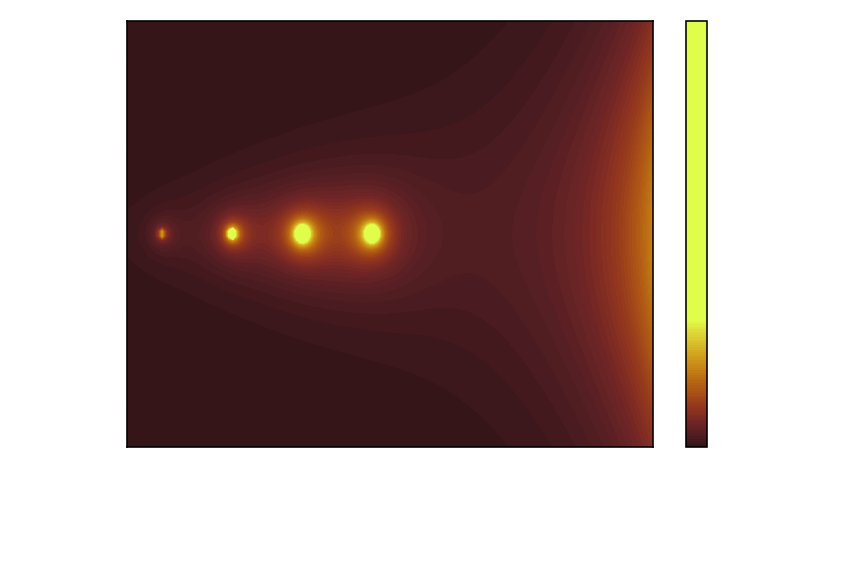

In [12]:
# MAKE FILLED CONTOUR PLOT OF SOLN
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()

CF = plt.contourf(X,Y,np.abs(gamma_samples), levels=200, cmap = cmo.solar)

# axis labels
plt.xlabel(r"Re$z$", fontsize=26, color = 'w')
plt.ylabel(r"Im$z$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color='w') 
cbar.ax.set_ylabel(r'$\left|\Gamma(z)\right|$', fontsize=26, color='w')
plt.clim(-0.01,10.)


cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color='w')

#fig.set_size_inches(8,6)

plt.tight_layout()

plt.show()

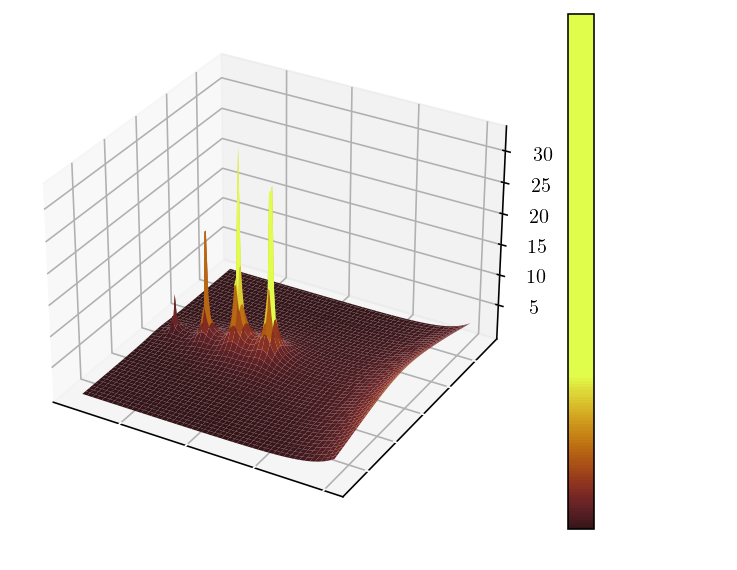

In [13]:
#TODO: polish this mesh plot up! 
# MAKE MESH PLOT OF SOLN
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X,Y,np.abs(gamma_samples), cmap = cmo.solar)

# axis labels
plt.xlabel(r"Re$z$", fontsize=26, color = 'w')
plt.ylabel(r"Im$z$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f', ax=ax)
cbar.ax.tick_params(labelsize=16, color='w') 
cbar.ax.set_ylabel(r'$\left|\Gamma(z)\right|$', fontsize=26, color='w')

cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color='w')

#fig.set_size_inches(8,6)

plt.tight_layout()

plt.show()

## Example 4: Function Evaluation via Cauchy Integrals

TODO: import our routine for handling $\phi_{1}$ numerically via the trapezoidal rule + Cauchy's formula. Perform a convincing accuracy study. 

In [14]:
def get_phi1(z, num_samples = 16):
    N = np.size(z)
    
    theta = np.linspace(0., 2.*np.pi, num = num_samples, endpoint= False)
        
    # as we saw with the Bessel fnc example, a slick use of numpy functions
    # allows us to evaluate phi1 without using a loop!
    z0 = np.tile(z,(num_samples,1)) + np.tile(np.exp(1j*theta) ,(N,1)).T
    
    phi1 = np.real(np.mean((np.exp(z0)-1.)/z0,0)) # note how we take mean over a certain axis

    return phi1

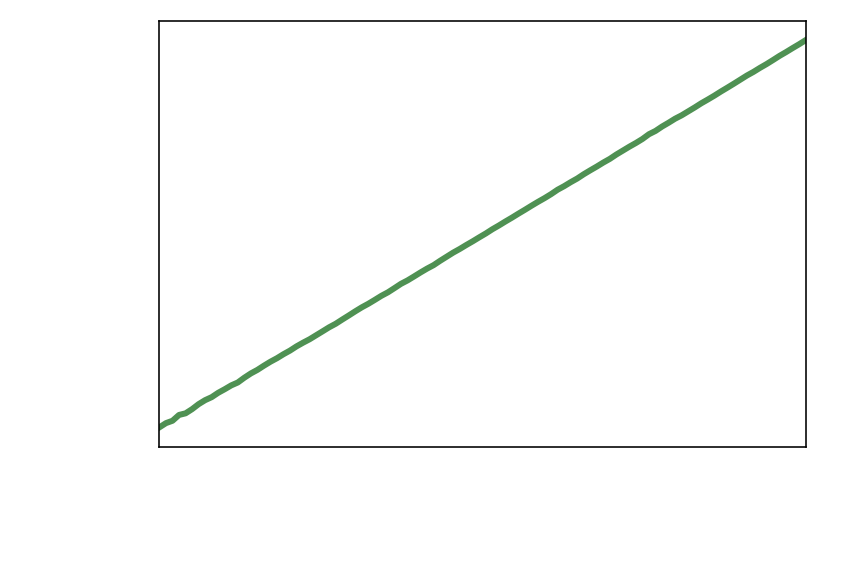

In [15]:
z = np.linspace(0.01,20, num = 100)

my_phi = get_phi1(z)

y = np.exp(z)
exact_phi = (y-1.)/np.log(y)

error = my_phi - exact_phi

plt.semilogy(z,error, color='xkcd:light forest green', linewidth='3')

plt.xlim([0.01,20])
#plt.ylim([-0.45,1.05])

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"Error", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

In [16]:
# TODO: further accuracy studies using the Taylor series... 
# give empirical evidence revisiting Kassam/Trefethen's reasoning that the Cauchy integral patches 
# together the direct approach when z>>1 and the Taylor series approach when z \approx 0. Make
# another graph (loglog plot) illustrating Taylor truncation vs. Cauchy integral to show that 
# the Cauchy integral does actually affect the patching. 